In [1]:
import json
import rasterio.mask
import requests
import shapely

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import seaborn as sns

from affine import Affine
from pathlib import Path
from rasterio.io import MemoryFile
from rasterio import DatasetBase
from scipy.interpolate import make_smoothing_spline
from shapely import Geometry
from typing import Callable, Sequence

In [2]:
ageb_path = Path(r"C:\Users\lain\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\population_grids_data\final\zone_agebs\shaped\2020")
merged_path = Path(r"C:\Users\lain\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\population_grids_data\final\reprojected\merged")
centroid_path = Path(r"C:\Users\lain\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\centroids\historical")

In [3]:
def overlay_geometries(ds: DatasetBase, geometries: Sequence[Geometry], func: Callable) -> list[float]:
    temps = []
    for geom in geometries:
        masked, _ = rio.mask.mask(ds, [geom], crop=True, nodata=-99999)
        masked[masked == -99999] = np.nan
        temps.append(func(masked))
    return temps

In [4]:
buffer_size = 10_000

bounds_map = {}
radii_map = {}
for path in merged_path.glob("*.gpkg"):
    df = gpd.read_file(path)
    centroid = gpd.read_file(centroid_path / f"{path.stem}.gpkg").to_crs(df.crs)["geometry"].item()

    xmin, ymin, xmax, ymax = df.total_bounds
    xmin -= buffer_size
    ymin -= buffer_size
    xmax += buffer_size
    ymax += buffer_size

    xmin, ymin, xmax, ymax = gpd.GeoSeries([shapely.box(xmin, ymin, xmax, ymax)], crs=df.crs).to_crs("EPSG:4326").total_bounds
    bounds_map[path.stem] = np.array([xmin, ymin, xmax, ymax]).tolist()

    df = (
        df
        .assign(dist=lambda df: df.distance(centroid))
        .sort_values("dist")
        .dropna(subset=["2020"])
        .set_index("dist")
        ["2020"]
    )

    thresh_idx = (df.cumsum() / df.sum()) >= 0.97
    thresh_idx = thresh_idx.idxmax()
    radii_map[path.stem] = thresh_idx

# SUHI Raster

In [5]:
for zone, (xmin, ymin, xmax, ymax) in bounds_map.items():
    if zone != "08.2.03":
        continue
    
    response = requests.get(
        "http://localhost:8000/suhi/raster/suhi",
        params=dict(
            xmin=xmin,
            ymin=ymin,
            xmax=xmax,
            ymax=ymax,
            year=2023,
            season="Qall",
        ),
    )

In [14]:
response_json = response.json()
data = np.reshape(response_json["data"], (response_json["height"], response_json["width"]))
with rio.open(
    "./test.tif",
    "w",
    driver="GTiff",
    height=response_json["height"],
    width=response_json["width"],
    count=1,
    dtype="float32",
    crs=response_json["crs"],
    transform=Affine(*response_json["transform"]),
    nodata=-99999,
    compress="lzw",
    ) as dst:
        dst.write(data, 1)

# Radial

In [ ]:
for zone, (xmin, ymin, xmax, ymax) in bounds_map.items():
    centroid = gpd.read_file(centroid_path / f"{zone}.gpkg").to_crs("EPSG:4326")["geometry"].item()

    df = gpd.read_file(ageb_path / f"{zone}.gpkg").to_crs("EPSG:4326")
    
    response = requests.get(
        "http://localhost:8000/suhi/data/radial",
        params=dict(
            xmin=xmin,
            ymin=ymin,
            xmax=xmax,
            ymax=ymax,
            year=2023,
            season="Qall",
            x=centroid.x,
            y=centroid.y,
        ),
    )
    
    if response.status_code != 200:
        continue

    test = response.json()
    x = np.array(test["radii"])
    mask = x <= radii_map[zone]

    x = x[mask]
    y = np.array(test["cdf"])[mask]

    np.save(f"./radial/{zone}_x.npy", x)
    np.save(f"./radial/{zone}_y.npy", y)

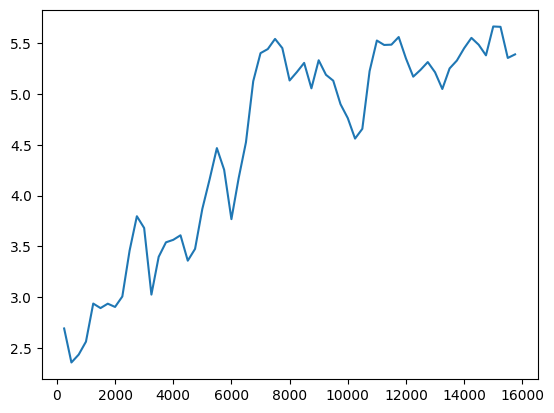

In [161]:
zone = "01.1.01"
x = np.load(f"./radial/{zone}_x.npy")
y = np.load(f"./radial/{zone}_y.npy", allow_pickle=True)

plt.plot(x, y, label="CDF")

In [31]:
for zone, (xmin, ymin, xmax, ymax) in bounds_map.items():    
    df = gpd.read_file(ageb_path / f"{zone}.gpkg").to_crs("EPSG:4326")

    response = requests.post(
        "http://localhost:8000/suhi/raster/suhi",
        data=json.dumps(dict(
            xmin=xmin,
            ymin=ymin,
            xmax=xmax,
            ymax=ymax,
            year=2023,
            season="Qall"
        )),
    )
    response_json = response.json()

    arr = np.reshape(response_json["data"], (response_json["height"], response_json["width"]))

    with MemoryFile() as memfile:
        with memfile.open(
            driver="GTiff",
            height=arr.shape[0],
            width=arr.shape[1],
            count=1,
            dtype=float,
            crs=response_json["crs"],
            transform=Affine(*response_json["transform"])
        ) as ds:
            ds.write(arr, 1)
            df["temp"] = overlay_geometries(ds, df["geometry"])
    # df = df.dropna(subset=["POBTOT", "temp"], how="any").reset_index(drop=True)
    break

In [33]:
pop = df.sort_values("temp").set_index("temp")["POBTOT"]
y = pop.cumsum() / pop.sum()
x = pop.index

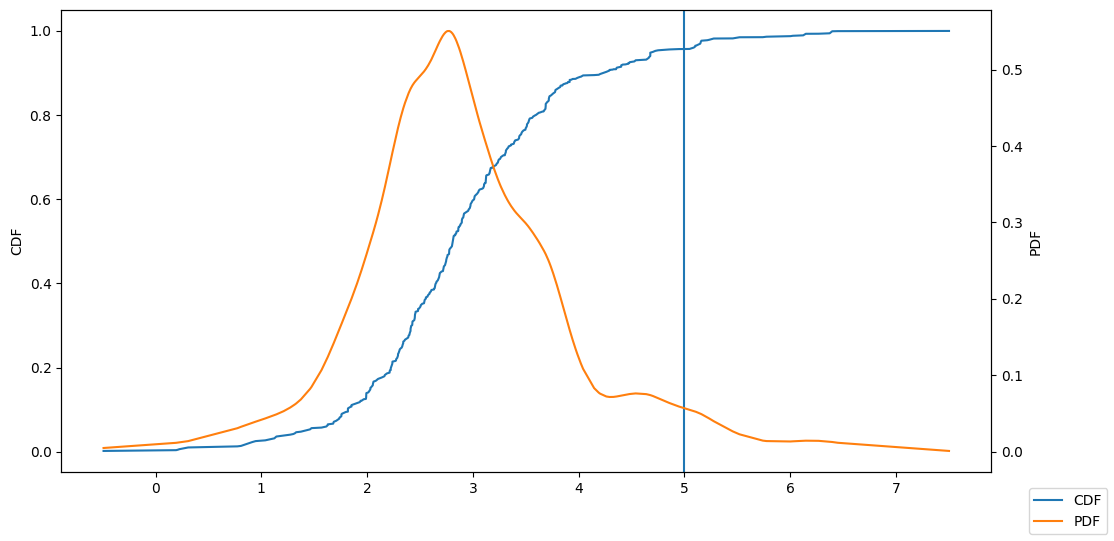

In [34]:
spline = make_smoothing_spline(x, y, lam=0.05)
pdf = spline.derivative()(x)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x, y, label="CDF")

ax2 = ax.twinx()
ax2.plot(x, pdf, c="C1", label="PDF")

ax.set_ylabel("CDF")
ax2.set_ylabel("PDF")
ax.axvline(5, 0, 1)

fig.legend(loc="lower right")